In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
secinyr = 60.0*60.0*24.0*365.0
k     = 250.0
rhos  = 12700
rhol  = 12100
cp    = 750
kappa = k/(rhol*cp)
Dliq  = 1e-9
Dsol  = 1e-12
mu    = 1e-6
drho  = rhos-rhol
g     = 3.7
Vic      = 4 * np.pi * 1221000.0**3 / 3.0
kb       = 1.380648e-23
secingyr = 3.1536e+16

r = np.logspace(-6,0,num=20)

In [3]:
tt = np.zeros(len(r))
ts = np.zeros(len(r))
tl = np.zeros(len(r))
tVl= np.zeros(len(r))

j = 0
for i in r:    
    tt[j] = i**2/kappa/secinyr
    ts[j] = i**2/Dsol/secinyr
    tl[j] = i**2/Dliq/secinyr
    
    Vs    = 2.0 * drho * g * i**2 / (9 * mu * rhol)
    tVl[j]= 100e3/Vs/secinyr
    
    #print("{:e}".format(i), "{:e}".format(tt), "{:e}".format(ts), "{:e}".format(tl))
    j = j + 1

In [4]:
def fzhang(u,r):
    Re  = 2*r * u / mu
    Cd  = (24.0/Re) * (1.0 + 0.15*Re**0.687) + 0.42/(1.0 + 42500*Re**-1.16)
    unum= 8.0 * g * r * drho
    uden= 3.0 * rhol * Cd
    u   = np.sqrt(unum/uden)
    return Re, Cd, u

In [5]:
def fzhang_opt(u,rad):
    return np.sqrt((8.0 * g * rad * drho) / (3.0 * rhol * 
          ( (24.0/(2*rad*u/mu) ) * (1.0 + 0.15*((2*rad*u/mu))**0.687) + 
                                    0.42/(1.0 + 42500*(2*rad*u/mu)**-1.16) ) )) - u

Classical Stokes flow velocity is given by

$$ V_S = \frac{2}{9} \frac{\Delta \rho g a^2}{\mu} $$

while the Zhang and Xu equation (20) gives

$$ V_Z = \sqrt{\left( \frac{8}{3} \frac{\Delta \rho g a}{\rho_l C_D} \right) }$$

The drag coefficient $C_D$ is 

$$ C_D = \frac{2F_D}{\rho_l V^2 A} = \frac{12 \pi \mu a}{\rho_l V A}, F_D = 6\pi \mu a V$$

As $Re$ increases the drag coefficient increases and so $V_Z$ tends to decrease compared to $V_S$. Hence the falling time should be greater for the high $Re$ case than the low $Re$ case at high $Re$. 

In [7]:
rad = 1e-2
u2 = optimize.brentq(fzhang_opt, -1.0, 1.0, args=(rad))

print('Re, Cd, ufinal, ubrent')
Re, Cd, uX = fzhang(u2,rad)
print(np.round(Re,1), np.round(Cd,5), np.round(uX,9), np.round(u2,9))

Re, Cd, ufinal, ubrent
2219.0 0.39743 0.110952099 0.110952099


In [8]:
tVh= np.zeros(len(r))

j = 0
print('Re, Cd, ufinal, ubrent')

for i in r:
    rad = np.float(i)
    Vs     = optimize.brentq(fzhang_opt, -1.0, 100.0, args=(rad))
    Re, Cd, uX = fzhang(Vs,rad)
    print(np.round(Re,9), np.round(Cd,5), np.round(uX,9), np.round(Vs,9))
    tVh[j] = 100e3/Vs/secinyr
    j = j + 1

Re, Cd, ufinal, ubrent
8.2e-08 294324808.3667 4.1e-08 4.1e-08
7.22e-07 33224994.59938 1.75e-07 1.75e-07
6.399e-06 3750806.29079 7.47e-07 7.47e-07
5.6678e-05 423524.42117 3.199e-06 3.199e-06
0.000501772 47869.30562 1.3687e-05 1.3687e-05
0.00443257 5434.0953 5.8436e-05 5.8436e-05
0.038785042 628.75047 0.000247114 0.000247114
0.32642133 78.63542 0.00100513 0.00100513
2.424424875 12.62776 0.00360797 0.00360797
14.204848566 3.25866 0.010216481 0.010216481
66.074103063 1.33419 0.02296712 0.02296712
267.283825845 0.72228 0.044901254 0.044901254
988.764535921 0.46755 0.080276643 0.080276643
3241.096924012 0.38548 0.127174156 0.127174156
9321.731237176 0.41282 0.176772193 0.176772193
26050.166323559 0.46828 0.238747262 0.238747262
75679.76231245 0.49151 0.335210941 0.335210941
226685.229037063 0.4853 0.485257408 0.485257408
685088.523067273 0.47069 0.708771376 0.708771376
2069054.448905178 0.45714 1.034527224 1.034527224


In [27]:
# Implement growth model of Kirkpatrick eqn 14, which does not invoke approximation K16
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth14(dT,Tl,eta,r):
    T = Tl - dT
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f*kB*T) / (3.0*np.pi*r**2*eta) * ( 1.0-np.exp( -(hf * dT)/(Rg*T*Tl) ) )
    return Y

In [28]:
# Implement growth model of Kirkpatrick eqn 17
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth17(dT,Tl,eta,r):
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f * kB) / (3.0 * np.pi * r**2 * eta) * (hf * dT) / (Rg * Tl)
    return Y

Interface timescale. 

Here I implement equation 17 of Kirkpatrick (1974). Below I refer to his equations as KX. 

- I assume that the growth rate is $da/dt$ where $a$ is particle radius
- Then time is $a/(da/dt)$
- I interpret this as the timescale required to grow the crystal to size a assuming that there are no diffusive hiderances to the process; the only obstacle seems to be the random detachment of particles from the surface according to K4.

- I take $f=1$
- Presumably we can check whether Stokes-Einstein is consistent with (say) Dario's calculations? 
- Dario validates that K13 is a pretty good approximation; I have not included the correction in our eqn 2 here. 

What about the aassumption in K16? I check this in the next cell and find that it seems to be a bad approximation. Therefore we use eqn 14. The main problems with this seem to be 
- Validity of Stokes-Einstein
- The assumption of an effective diffusion coefficient in eqn K9

In [29]:
hf = 0.976e10 # From Dario
dT = 1.0      # 1 K undercooling
Tl = 6500.0   # Melting T of pure iron, high value

print(hf*dT/Tl, 8.314462*Tl)

1501538.4615384615 54044.003000000004


In [30]:
Tm_FeO = 5600.0
dT     = 200.0
tI     = np.zeros(len(r))

j = 0
for i in r:
    G = kirk_growth14(dT,Tm_FeO,0.01,i)
    tI[j] = i/G/secinyr
    j = j + 1

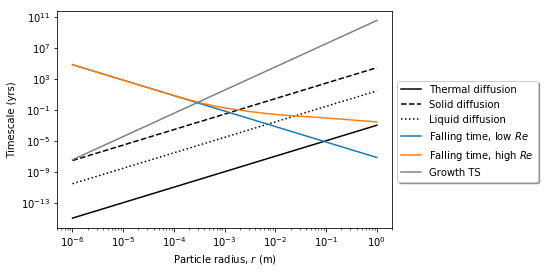

In [31]:
plt.xlabel("Particle radius, $r$ (m)")
plt.ylabel("Timescale (yrs)")
plt.loglog(r, tt , color="black", linestyle="-",label="Thermal diffusion")
plt.loglog(r, ts , color="black", linestyle="--", label="Solid diffusion")
plt.loglog(r, tl , color="black", linestyle=":", label="Liquid diffusion")
plt.loglog(r, tVl, label="Falling time, low $Re$")
plt.loglog(r, tVh, label="Falling time, high $Re$")
plt.loglog(r, tI , color="grey" , label="Growth TS")
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.7),
          fancybox=True, shadow=True)

In [32]:
# Stokes-Einsten relation
# kB in J/K; eta in Pa.s = Js/m^3; r in m
# D ~ J/K . K . m^3 / Js . 1/m = m^2 / s
def StokesEinstein(T,eta,r):
    kB = 1.380649e-23 #J/K
    return kB*T/(6.0*np.pi*eta*r)

In [17]:
Dcore = StokesEinstein(5500.0,0.01,1e-8)
Dcore

4.028513738789507e-11